In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas_profiling as pdp
import os
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from pyclustering.cluster import gmeans, xmeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn import metrics
import itertools
import math
import ipyparallel as ipp
from multiprocessing import cpu_count,Pool

import sys
sys.path.append("c:\\Users\\xxp2p\\anaconda3\\envs\\yt_38\\lib\\site-packages\\stock_tools-0.0.1.dev96+gbf29348.d20230309-py3.8.egg\\stock_tools\\")
# sys.path.append(r"C:/Users/ryota/sys_trading/stock_tools/src/stock_tools/")
import add_technical, trading_def

COST = 4 / 10000

import ta

def preproces_plusdata(df):
    code = df["CODE"].unique()[0]
    if code <= 2:
        df = df.rename(columns={"Unnamed: 0":"DATE"})
    df[["MARKET","SEC"]] = df[["MARKET","SEC"]].fillna(method="bfill")
    df["DATE"] = pd.to_datetime(df["DATE"])  
    df = df.set_index("DATE")
    return df

def add_stop_factor(df,limit):
    """
    2020年8月3日より4倍値幅は2営業日連続寄らずにストップが行われた翌営業から
    それ以前は、3営業日
    """
    # s高安張り付き判定(値幅拡大前)
    df["stop_limit"] = df["CLOSE"].apply(
        lambda x : limit.loc[np.sum(limit["価格帯"] <= x),"値幅上下限"]
    ).shift()
    df["is_stop_low"] = df.LOW == df.CLOSE.shift() - df["stop_limit"]
    df["is_stop_low_alltime"] = (df.HIGH == df.CLOSE.shift() - df["stop_limit"]) & (df.LOW == df.CLOSE.shift() - df["stop_limit"])
    df["is_stop_high"] = df.LOW == df.CLOSE.shift() + df["stop_limit"]
    df["is_stop_high_alltime"] = (df.HIGH == df.CLOSE.shift() + df["stop_limit"]) & (df.LOW == df.CLOSE.shift() + df["stop_limit"])
    return df

# rankの評価関数
# https://www.szdrblog.info/entry/2017/02/24/235539
def ndcg(y_true, y_pred, k=None, powered=False):
    def dcg(scores, k=None, powered=False):
        if k is None:
            k = scores.shape[0]
        if not powered:
            ret = scores[0]
            for i in range(1, k):
                ret += scores[i] / np.log2(i + 1)
            return ret
        else:
            ret = 0
            for i in range(k):
                ret += (2 ** scores[i] - 1) / np.log2(i + 2)
            return ret
    
    ideal_sorted_scores = np.sort(y_true)[::-1]
    ideal_dcg_score = dcg(ideal_sorted_scores, k=k, powered=powered)
    
    pred_sorted_ind = np.argsort(y_pred)[::-1]
    pred_sorted_scores = y_true[pred_sorted_ind]
    dcg_score = dcg(pred_sorted_scores, k=k, powered=powered)
    
    return dcg_score / ideal_dcg_score

def ndcg1(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=False)

def ndcg2(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=True)

%reload_ext autoreload
%autoreload 2

C:\Users\xxp2p\AppData\Local\Temp/ipykernel_24232/3012272955.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pdp


In [2]:
import os
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import jquantsapi
import json
from visualization import visualization as vi

# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [3]:
import inspect
print(inspect.getsource(vi))

class visualization:
    def __init__(self):
        """ """

    def chart(self, df, technical_list=[], oscillator_list=[]):
        """
        チャートとオシレーターを表示する
        :param df 株価のdataframe
        :param technical_list:list of str  表示したいテクニカルのcolumnsリスト
        :param oscillator_list:list of str  表示したいオシレーターのcolumnsリスト
        :return チャート
        """
        # jpxのdateカラムはDateのため変換
        if "date" not in df.columns:
            df = df.rename(
                columns={
                    f"Adjustment{c}": f"fix_{c.lower()}"
                    for c in ["Open", "High", "Low", "Close"]
                }
            )
            df = df.rename(columns={"Date": "date", "Code": "CODE"})
        code = df["CODE"].iloc[0]
        # subplotsで複数のグラフ画面を作成する
        if len(oscillator_list) != 0:
            heights_list = np.ones(1 + len(oscillator_list))  # row_heightsグラフ高さ倍率リストの作成
            heights_list[0] = 3  # 一つ目のグラフとそれ以降の倍率を3：1にしている
            heights_list = heights_list.toli

todo　0208~　　ここから


０、goal設定（具体的に何を出したいか決め、それを出すためにどんな処理が必要か考える）

１，visualyzationをつかってみて使い方思い出す。入れるべき値はどんなものなのか実験する。pairchart ok
df（etfと個別）　、　期間(20001130、20230101）とかの数列startとend　この二つをcodeキーで辞書に格納する

２，jquants-apiで個別のdfs＋財務で一つの新df（df_ipo_inspection）つくる
→次回の反省材料。今回は現コードでやる 今回はやらない

３，dfsつくる
やらない

４，仮説を証明する

５、途中経過に認識があっているか確認する

ここで財務と株価を合成したdf作って全銘柄分を辞書に格納するdfs =｛code:df}

df_ipo_inspection作成
・ipoの情報をカラムで追加していく
・例えば上場前後30日の行のみにソートして、複数銘柄分混ぜてdfに格納する

dict_target_changeという辞書に格納↓
dict_target_change[code] = (
        df_mothers_price_ba60days,（当選発表日から30日前～30日後のdfを時系列データで保存）
        mothers_change_from_dt_get_ipo,   →次はこれの意味を理解する20230209 14:22　　koko！
        mothers_change_from_dt_ipo,
    )
現在0209　14:00

ここから旧コード

In [4]:
import os
import datetime

import japanize_matplotlib
import jquantsapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)
     


In [5]:
df_schedule = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_schedule_0120.csv", encoding='utf-8_sig')
df_assessments = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_assessments_0131.csv", encoding='utf-8_sig')
df_shareholders = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_shareholders_0120.csv", encoding='utf-8_sig')
df_underwriters = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_underwriters_0120.csv", encoding='utf-8_sig')
# 2020/10/01の東証のシステム障害日の行は無い

In [6]:
# リフレッシュトークンの更新　メールアドレスとパスワード漏洩注意
# https://ku-ai-trade.com/j-quants-api/
data={"mailaddress":"xxp2pnxuf@gmail.com", "password":"Momiyama1"}

# data={"mailaddress":"登録したメアド", "password":"登録したpass"}
r_post = requests.post("https://api.jpx-jquants.com/v1/token/auth_user", data=json.dumps(data))
r_post.json()
# トークン取得
refresh_token = r_post.json()['refreshToken']
# J-Quants APIクライアントを初期化します
jqapi = jquantsapi.Client(refresh_token=refresh_token)
# 銘柄情報を取得します
df_list = jqapi.get_list()

In [7]:
df_mothers_price = jqapi.get_prices_daily_quotes(code=2516)
df_mothers_price["oc_change"] = df_mothers_price["AdjustmentClose"] / df_mothers_price["AdjustmentOpen"] - 1
df_mothers_price["cc_change"] = df_mothers_price["AdjustmentClose"] / df_mothers_price["AdjustmentOpen"].shift(1) - 1
df_mothers_price['oc_change'] = df_mothers_price['oc_change'].fillna(0)
df_mothers_price['cc_change'] = df_mothers_price['cc_change'].fillna(0)
df_mothers_price = df_mothers_price.fillna(method='ffill')
df_mothers_price = df_mothers_price.dropna(subset=["AdjustmentOpen"]).reset_index(drop=True)

In [8]:
# 欠損値の確認
df_mothers_price[df_mothers_price[["cc_change"]].isnull().any(axis=1)]

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue,AdjustmentFactor,AdjustmentOpen,AdjustmentHigh,AdjustmentLow,AdjustmentClose,AdjustmentVolume,oc_change,cc_change


ここで検証コードつくってみる

In [9]:
# ipo検証用のdf作成[1]

# 期末発行済株式数カラム作成用コード
df_fin_firsts = pd.DataFrame()
for i in df_assessments["code"].values:
# for i in [3277]:実験用
    df_fin_first = jqapi.get_fins_statements(code=i)
    df_fin_first["期末発行済株式数"] = df_fin_first["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]
    df_fin_first["期末発行済株式数"] = pd.to_numeric(df_fin_first["期末発行済株式数"], errors='raise', downcast=None)
    df_fin_first["期末発行済株式数"] = df_fin_first["期末発行済株式数"].fillna(method='ffill')
    df_fin_first["期末発行済株式数"] = df_fin_first["期末発行済株式数"].fillna(method='bfill')
    df_fin_firsts = pd.concat([df_fin_firsts,df_fin_first.iloc[:1,:]], axis=0)
# df_fin_firsts["期末発行済株式数"]

In [10]:
# ipo検証用のdf作成[2]

# indexのリセット 
df_fin_firsts = df_fin_firsts.reset_index(drop=True)
# mergeのためにcode列を作成し文字列型で最後の０を抜く
df_fin_firsts["code"] = df_fin_firsts["LocalCode"]
# 最後の一文字を消す
df_fin_firsts["code"] = df_fin_firsts["code"].str[:-1]
# 数値型に変更
df_fin_firsts["code"] = df_fin_firsts["code"].astype(int)
# 必要なカラムのみ残す
df_fin_firsts["期末発行済株式数_開示日"] = df_fin_firsts["DisclosedDate"]
df_fin_firsts = df_fin_firsts[[
    "code",
    "期末発行済株式数",
    "期末発行済株式数_開示日"
]]
# merge
df_ipo_inspection = df_assessments[[
    "code",
    "初値（円）",
    "公募価格（円）",
    "想定価格（円）",
    "上場市場"
    ]]

df_ipo_inspection = pd.merge(df_ipo_inspection,df_fin_firsts, on="code", how="inner")
df_schedule_ipo = df_schedule[[
    "code",
    '当選発表日',
    '上場日',
    '公募株数（株）',
    '売出株数（OA含む）（株）',
    '当選株数合計（株）'
]]

df_ipo_inspection = pd.merge(df_ipo_inspection,df_schedule_ipo, on="code", how="inner")


# 時価総額カラム作成
df_ipo_inspection["時価総額_公募価格（円）"] = df_ipo_inspection["期末発行済株式数"] * df_ipo_inspection["公募価格（円）"]
df_ipo_inspection["時価総額_初値"] = df_ipo_inspection["期末発行済株式数"] * df_ipo_inspection["初値（円）"]

# 公募＋売出の総額
df_ipo_inspection["公募売出総額_公募価格（円）"] = df_ipo_inspection["当選株数合計（株）"] * df_ipo_inspection["公募価格（円）"]
df_ipo_inspection["公募売出総額_初値"] = df_ipo_inspection["当選株数合計（株）"] * df_ipo_inspection["初値（円）"]

# datetime
df_ipo_inspection["上場日"] = pd.to_datetime(df_ipo_inspection["上場日"])
df_ipo_inspection["当選発表日"] = pd.to_datetime(df_ipo_inspection["当選発表日"])

df_first = df_ipo_inspection.reset_index().groupby("code").first()
# マザーズETFのデータの日付最小値でソート。もし当選発表日以前から検証したければここで日数をマイナスする
df_first = df_first[df_first["上場日"] >= df_mothers_price.Date.min()]

In [11]:
df_mothers_price.Date.min()

Timestamp('2018-02-01 00:00:00')

In [12]:
dict_target_change = {}
for code in df_first[df_first["時価総額_公募価格（円）"] >= 500 * 10000**2].index:
    df_ipo = df_first.loc[code]
    dt_ipo, dt_get_ipo = df_ipo[["上場日", "当選発表日"]]
    df_mothers_price_ba60days = df_mothers_price.loc[
        (df_mothers_price.Date <= dt_get_ipo + datetime.timedelta(days=60))
        & (df_mothers_price.Date >= dt_get_ipo - datetime.timedelta(days=60))
    ].set_index("Date")
    if len(df_mothers_price_ba60days) == 0:
        continue
    
    # 当選発表日からのマザーズ騰落率
    # 初日はより引け
    df_mothers_price_from_dt_get_ipo = df_mothers_price_ba60days.loc[
        df_mothers_price_ba60days.index >= dt_get_ipo, "Close"
    ]
    mothers_change_from_dt_get_ipo = (
        df_mothers_price_from_dt_get_ipo / df_mothers_price_from_dt_get_ipo.iloc[0] - 1
    )
    mothers_change_from_dt_get_ipo.iloc[0] = (
        df_mothers_price_ba60days.loc[dt_get_ipo]["Close"]
        / df_mothers_price_ba60days.loc[dt_get_ipo]["Open"]
        - 1
    )
    less = 60 - len(mothers_change_from_dt_get_ipo)
    mothers_change_from_dt_get_ipo = np.concatenate([mothers_change_from_dt_get_ipo.values,np.zeros(less) * np.nan])

    # 上場日からのマザーズ騰落率
    # 初日はより引け
    df_mothers_price_from_dt_ipo = df_mothers_price_ba60days.loc[
        df_mothers_price_ba60days.index >= dt_ipo, "Close"
    ]
    mothers_change_from_dt_ipo = (
        df_mothers_price_from_dt_ipo / df_mothers_price_from_dt_ipo.iloc[0] - 1
    )
    mothers_change_from_dt_ipo.iloc[0] = (
        df_mothers_price_ba60days.loc[dt_ipo]["Close"]
        / df_mothers_price_ba60days.loc[dt_ipo]["Open"]
        - 1
    )
    less = 60 - len(mothers_change_from_dt_ipo)
    mothers_change_from_dt_ipo = np.concatenate([mothers_change_from_dt_ipo.values,np.zeros(less) * np.nan])
    dict_target_change[code] = (
        df_mothers_price_ba60days,
        mothers_change_from_dt_get_ipo,
        mothers_change_from_dt_ipo,
    ) 

In [13]:
# 2個抽出した銘柄が多い
len(list(dict_target_change.keys()))

31

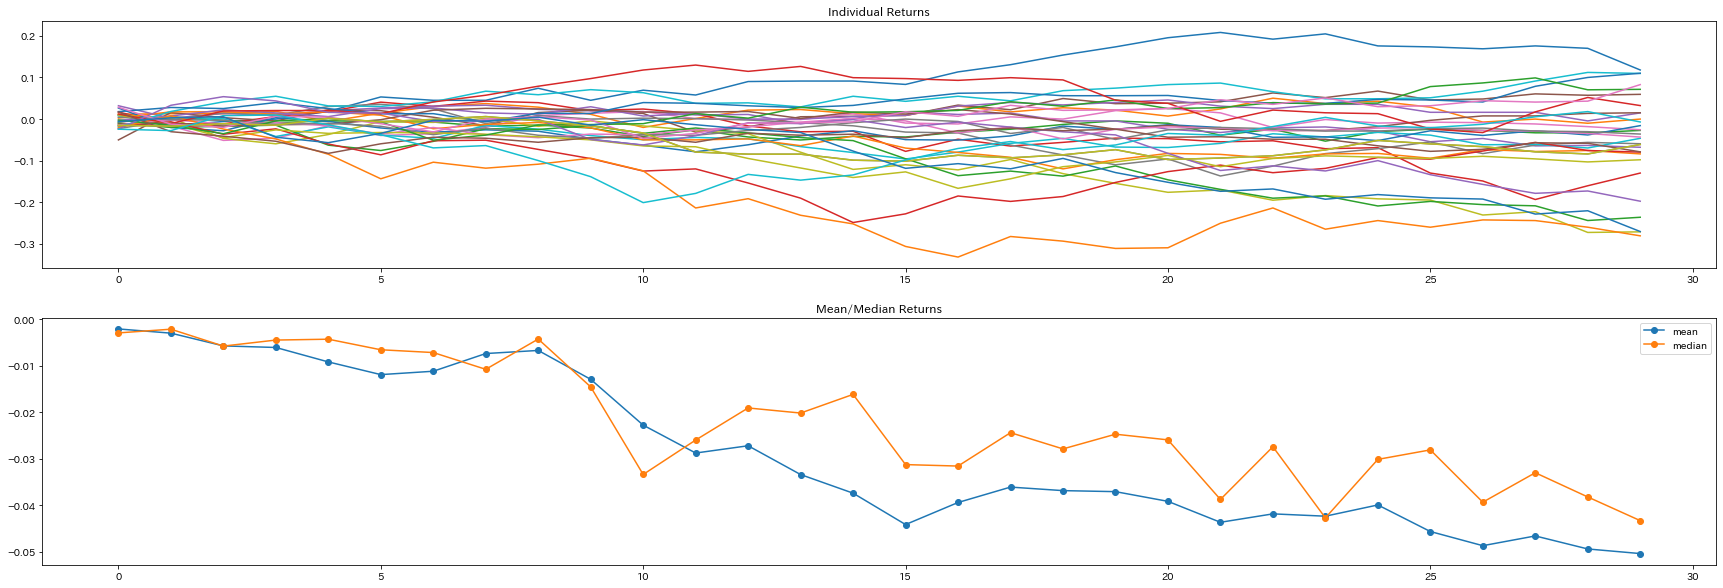

In [14]:
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(2, 1, 1)   #２行１列の１番目
for code in dict_target_change.keys():
    ax1.plot(dict_target_change[code][1][:30])
ax1.set_title("Individual Returns")

ax2 = fig.add_subplot(2, 1, 2)   #２行１列の２番目
ax2.plot(
    np.mean([dict_target_change[code][1][:30] for code in dict_target_change.keys()],axis=0),
    marker='o',
    label="mean"
)
ax2.plot(
    np.median([dict_target_change[code][1][:30] for code in dict_target_change.keys()],axis=0),
    marker='o',
    label="median"
)
ax2.set_title("Mean/Median Returns")
plt.legend()
plt.show()

In [15]:
8.368500e+10 / 10000**2

836.85

ここまでは前回の復習

In [16]:
# 仮説をたてるところまで　visualyzation.pyへの引数、codeごとの値を辞書化　

dict_target_change_ipo = {}
# 銘柄ソートをここでする
# df_first_sort = df_first.loc[((df_first["上場市場"] == "東証1部") | (df_first["上場市場"] == "東証プライム")) & (df_first["時価総額_公募価格（円）"] > 500 * 10000**2)]
df_first_sort = df_first.loc[((df_first["上場市場"] == "マザーズ") | (df_first["上場市場"] == "東証グロース")) & (df_first["時価総額_公募価格（円）"] > 500 * 10000**2)]
# df_first_sort = df_first.loc[(df_first["時価総額_公募価格（円）"] > 500 * 10000**2)]

for code in df_first_sort.index:
    df_ipo = df_first.loc[code]
    df_ipo
    dt_ipo, dt_get_ipo = df_ipo[["上場日", "当選発表日"]]
    df_mothers_price_90days = df_mothers_price.loc[
        (df_mothers_price.Date <= dt_ipo + datetime.timedelta(days=90))
        & (df_mothers_price.Date >= dt_ipo)
    ]
    if len(df_mothers_price_90days) == 0:
        continue
    df_mothers_price_90days = df_mothers_price_90days.reset_index(drop=True)
    
    # 個別ipo銘柄の値動き
    df_ipo_price_ba90days = jqapi.get_prices_daily_quotes(code=code)
    df_ipo_price_ba90days = df_ipo_price_ba90days.fillna(method='ffill')


    df_ipo_price_ba90days = df_ipo_price_ba90days.loc[
        (df_ipo_price_ba90days.Date <= dt_ipo + datetime.timedelta(days=90))
    ]
    df_ipo_price_ba90days = df_ipo_price_ba90days.reset_index(drop=True)
    # もし上場日寄り付かなかった場合の処理
    # 1行目がNaNであるかどうかを確認する
    while pd.isna(df_ipo_price_ba90days.iloc[0]['Close']):
        # 1行目がNaNである場合、1行目を削除する
        df_ipo_price_ba90days = df_ipo_price_ba90days.drop(0)
        df_ipo_price_ba90days = df_ipo_price_ba90days.reset_index(drop=True)


        df_mothers_price_90days = df_mothers_price_90days.drop(0)
        df_mothers_price_90days = df_mothers_price_90days.reset_index(drop=True)
    # 日付start作成 日付調整するならここ！
    ipo_start = dt_ipo

    # 日付end作成 日付調整するならここ！
    ipo_end = dt_ipo + datetime.timedelta(days=90)



    dict_target_change_ipo[code] = (
        df_mothers_price_90days,
        df_ipo_price_ba90days,
        ipo_start,
        ipo_end
    )

    

In [17]:
df_first["上場市場"].unique()

array(['東証1部', '名証', 'マザーズ', '札証', 'JASDAQスタンダード', '東証2部', '東証グロース',
       '東証REIT', '福証', '東証スタンダード', '東証プライム', '未定'], dtype=object)

In [18]:
from visualization import visualization as vi
vi = vi()

In [19]:
display(df_first.loc[((df_first["上場市場"] == "マザーズ") | (df_first["上場市場"] == "東証グロース")) & (df_first["時価総額_公募価格（円）"] > 500 * 10000**2)])

,index,初値（円）,公募価格（円）,想定価格（円）,上場市場,期末発行済株式数,期末発行済株式数_開示日,当選発表日,上場日,公募株数（株）,売出株数（OA含む）（株）,当選株数合計（株）,時価総額_公募価格（円）,時価総額_初値,公募売出総額_公募価格（円）,公募売出総額_初値
code,,,,,,,,,,,,,,,,
4071,837,2720.0,2300.0,1940.0,マザーズ,40050000.0,2021-08-13,2021-06-21,2021-06-30,50000.0,10866300.0,10916300.0,9.211500e+10,1.089360e+11,2.510749e+10,2.969234e+10
4165,688,3190.0,1600.0,1400.0,マザーズ,36945900.0,2021-02-12,2020-12-07,2020-12-17,1522000.0,13533000.0,3338500.0,5.911344e+10,1.178574e+11,5.341600e+09,1.064982e+10
4180,866,2030.0,1600.0,1400.0,マザーズ,99872490.0,2021-05-12,2021-03-22,2021-03-30,9101000.0,9531200.0,5885100.0,1.597960e+11,2.027412e+11,9.416160e+09,1.194675e+10
4194,859,7150.0,5000.0,4355.0,マザーズ,35591100.0,2021-06-07,2021-04-12,2021-04-22,2127700.0,11515600.0,13643300.0,1.779555e+11,2.544764e+11,6.821650e+10,9.754960e+10
4259,776,1030.0,1150.0,1050.0,マザーズ,79853400.0,2022-02-14,2021-12-15,2021-12-23,4000000.0,28407200.0,32407200.0,9.183141e+10,8.224900e+10,3.726828e+10,3.337942e+10
4375,811,3350.0,2430.0,2280.0,マザーズ,49147700.0,2021-11-12,2021-09-17,2021-09-29,3297700.0,7062300.0,10360000.0,1.194289e+11,1.646448e+11,2.517480e+10,3.470600e+10
4385,551,5000.0,3000.0,2450.0,マザーズ,135339722.0,2018-08-09,2018-06-11,2018-06-19,18159500.0,25395300.0,19599700.0,4.060192e+11,6.766986e+11,5.879910e+10,9.799850e+10
4419,783,990.0,1290.0,1290.0,マザーズ,48754628.0,2022-02-14,2021-12-13,2021-12-22,2800000.0,14996900.0,17796900.0,6.289347e+10,4.826708e+10,2.295800e+10,1.761893e+10
4443,636,4760.0,4500.0,4075.0,マザーズ,29432353.0,2019-07-12,2019-06-07,2019-06-19,500000.0,8136500.0,8636500.0,1.324456e+11,1.400980e+11,3.886425e+10,4.110974e+10


In [20]:
for code in dict_target_change_ipo.keys():
    print(code)
    # strftimeで文字列型に変換して、int()関数で変換
    start = dict_target_change_ipo[code][2].strftime('%Y%m%d')
    end = dict_target_change_ipo[code][3].strftime('%Y%m%d')
    vi.pairchart(dict_target_change_ipo[code][0],dict_target_change_ipo[code][1],start,end,indexing=True)
    # df確認用　下2行
    # print(dict_target_change_ipo[code][0])
    # print(dict_target_change_ipo[code][1])

4071


4165


4180


4194


4259


4375


4385


4419


4443


4448


4478


4483


7342


7806


9204


9522


In [21]:
df1 = dict_target_change_ipo[code][0]
df2 = dict_target_change_ipo[code][1]

In [22]:
# 20230309 1000
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def pairchart(
    df1,
    df2,
    start_day=0,
    end_day=99999999,
    indexing=True,
    corr=True,
    corr_span=5,
    add_volume=False,
    add_volume_log=False,
    diff=True,
):
    # 引数追加 , start_day, end_day
    """
    visualization.pairchart(df1,df2,スタート日付{"20200101"},エンド日付)
    これで出せるようにしてほしい
    """
    """
    ペアチャートを表示する
    :param df1:df 基準とする株価のdataframe
    :param df2:df 株価のdataframe
    :param start_day:int (例20200101) 表示期間の始まりの日
    :param end_day:int(例20200101) 表示期間の終わりの日
    :param indexing:bool Trueなら上段の株価終値を100を基準とした終値指数化に変更
    :param corr:bool Trueなら下段に相関分析を表示する
    :param corr_span:int corrの計算期間の変更
    :param add_volume:bool Trueなら下段に出来高表示する
    :param add_volume_log:bool Trueなら出来高の表示をlog表示にする（底は10で固定）
    :param diff:bool Trueなら上段の値の差分を2軸目に表示する
    :return ペアチャート
    """
    # １　データの前処理はここ
    # jpxのdateカラムはDateのため変換
    if "date" not in df1.columns:
        df1 = df1.rename(
            columns={
                f"Adjustment{c}": f"fix_{c.lower()}"
                for c in ["Open", "High", "Low", "Close","Volume"]
            }
        )
        df1 = df1.rename(columns={"Date": "date", "Code": "CODE"})
    if "date" not in df2.columns:
        df2 = df2.rename(
            columns={
                f"Adjustment{c}": f"fix_{c.lower()}"
                for c in ["Open", "High", "Low", "Close","Volume"]
            }
        )
        df2 = df2.rename(columns={"Date": "date", "Code": "CODE"})
    code1 = df1["CODE"][0]
    code2 = df2["CODE"][0]
    # 期間範囲指定
    df1 = df1[(df1["date"] >= f"{start_day}") & (df1["date"] <= f"{end_day}")]
    df2 = df2[(df2["date"] >= f"{start_day}") & (df2["date"] <= f"{end_day}")]
    # 指数化の計算
    if indexing == True:
        df1 = df1.reset_index()
        df1["fix_close"] = df1["fix_close"] / df1["fix_close"][0] * 100
        df2 = df2.reset_index()
        df2["fix_close"] = df2["fix_close"] / df2["fix_close"][0] * 100
    # 差分の作成
    if diff == True:
        param_diff = df1["fix_close"] - df2["fix_close"]
        param_name_diff = "差分"
    param_name= ""
    # 相関係数の作成
    if corr == True:
        param = df1["fix_close"].rolling(corr_span).corr(df2["fix_close"])
        param_name = "相関分析"
    # 出来高にparam変更
    if add_volume == True:
        param_name = "出来高"
    # ２　make_subplots設定はここ
    # subplotsで複数のグラフ画面を作成する
    row_heights_param = [3, 1]
    row_param = 2
    # 出来高のsubplots設定変更（3:2のおおきさに変更)
    if add_volume == True:
        row_heights_param[1] = 2
    fig = make_subplots(
        rows=row_param,  # 行数設定
        cols=1,  # 列数設定
        # shared_yaxes='all', #y軸を共有する
        shared_xaxes="all",  # x軸を共有する
        vertical_spacing=0.1,  # サブプロット行間のスペース
        row_heights=row_heights_param, # グラフの大きさ 相対的比率
        subplot_titles=["chart", param_name],  # グラフ上のタイトル設定
        specs=[[{"secondary_y": True}], [{}]], #2軸目追加
    )
    # ３　add_trace グラフの挿入はここ
    # add_traceでグラフを入れる
    fig.add_trace(
        go.Scatter(
            x=df1["date"],
            y=df1["fix_close"],
            mode="lines",
            name=f"{code1}",
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=df1["date"],
            y=df2["fix_close"],
            mode="lines",
            name=f"{code2}",
        ),
        row=1,
        col=1,
    )
    if diff == True:
        fig.add_trace(
            go.Scatter(
                x=df1["date"],
                y=param_diff,
                mode="lines",
                name=f"{param_name_diff}",
                marker_color="gold",
            ),
            row=1,
            col=1,
            secondary_y=True,
        )
        fig.update_yaxes(
            title_text="差分",  # 2軸目のラベル設定
            row=1,
            col=1,
            secondary_y=True,  # 2軸目の軸を設定
        )
    # 下段に差分または相関係数のグラフを作成する
    if (corr == True) and (add_volume == False):
        fig.add_trace(
            go.Scatter(
                x=df1["date"],
                y=param,
                mode="lines",
                name=param_name,
                marker_color="limegreen",
            ),
            row=2,
            col=1,
        )
    if add_volume == True:
        fig.add_trace(
            go.Bar(
                x=df1["date"],
                y=df1["fix_volume"],
                # mode="lines",
                name=f"{code1}",
                opacity=0.3,
                marker_color="blue",
            ),
            row=2,
            col=1,
            # secondary_y=True,
        )
        fig.add_trace(
            go.Bar(
                x=df2["date"],
                y=df2["fix_volume"],
                # mode="lines",
                name=f"{code2}",
                opacity=0.3,
                marker_color="red",
            ),
            row=2,
            col=1,
            # secondary_y=True,
        )
    # ４　レイアウト設定はここ
    # layoutでレイアウト設定をする
    height_param = 800
    if add_volume == True:
        height_param += 100
    fig.update_layout(
        # グラフタイトル
        # title_text="OHLC",
        # 凡例表示
        showlegend=True,
        # 凡例の位置変更
        xaxis_rangeslider=dict(
            visible=False,
        ),  # レンジスライダー削除
        yaxis=dict(fixedrange=False),  # y軸のズームを可能にする
        height=height_param,  # グラフ高さの編集
        width=900,  # グラフ横幅の編集
        margin=dict(l=0, r=0, t=30, b=0), #グラフ間の隙間幅の調整
    )
    # 土日祝の隙間を削除するためにrangebreaks作成して、update_xaxesで反映させる
    # 日付objectをdatetime型に変換
    date = pd.to_datetime(df1["date"])
    # 日付リストを取得
    d_all = pd.date_range(start=df1["date"].iloc[0], end=df1["date"].iloc[-1])
    # 株価データの日付リストを取得
    d_obs = [d.strftime("%Y-%m-%d") for d in date]
    # 株価データの日付データに含まれていない日付を抽出
    d_breaks = [d for d in d_all.strftime("%Y-%m-%d").tolist() if not d in d_obs]
    fig.update_xaxes(rangebreaks=[dict(values=d_breaks)])
    # ５　追加レイアウト設定はここ
    # 相関分析時にy軸の最大最小値の固定化
    if (corr == True) and (add_volume == False):
        fig.update_yaxes(range=[-1, 1], row=2, col=1)
    # y軸をlogに変更する
    if (add_volume == True) and (add_volume_log == True):
        fig.update_yaxes(type="log", row=2, col=1)
    # グラフ出力
    fig.show()

In [23]:
pairchart(df1,df2,start,end,indexing=True,corr=True,corr_span=5,add_volume=True,add_volume_log=True,diff=True)


In [33]:
for code in dict_target_change_ipo.keys():
    print(code)
    # strftimeで文字列型に変換して、int()関数で変換
    start = dict_target_change_ipo[code][2].strftime('%Y%m%d')
    end = dict_target_change_ipo[code][3].strftime('%Y%m%d')
    vi.pairchart(dict_target_change_ipo[code][0],dict_target_change_ipo[code][1],start,end,indexing=False,corr=True,corr_span=5,diff=False,add_volume=True,add_volume_log=True)
    # df確認用　下2行
    # print(dict_target_change_ipo[code][0])
    # print(dict_target_change_ipo[code][1])

4071


4165


4180


4194


4259


4375


4385


4419


4443


4448


4478


4483


7342


7806


9204


9522


複数銘柄可視化3/1～

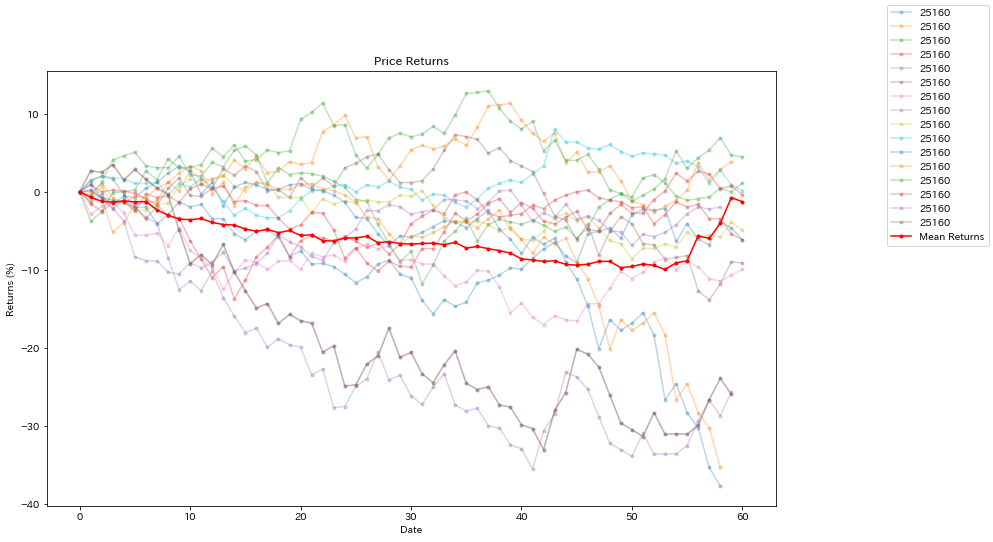

In [25]:
# is_plot_mean
df_list = [dict_target_change_ipo[code][0] for code in dict_target_change_ipo.keys()] 
vi.multiplot_matplotlib(df_list, day_period=60, is_plot_mean=True, is_plot_mean_alpha=0.3, log_y=False, log_y_base=10, log_y_linthresh=10.0)  # 複数のチャートを表示する

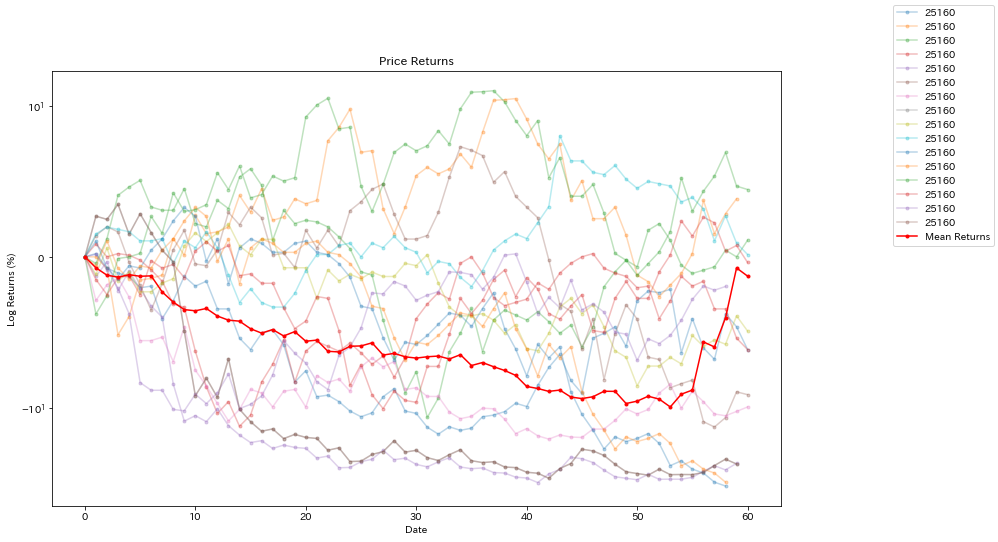

In [26]:
# is_plot_mean (log表示)
df_list = [dict_target_change_ipo[code][0] for code in dict_target_change_ipo.keys()] 
vi.multiplot_matplotlib(df_list, day_period=60, is_plot_mean=True, is_plot_mean_alpha=0.3, log_y=True, log_y_base=10, log_y_linthresh=10.0)  # 複数のチャートを表示する

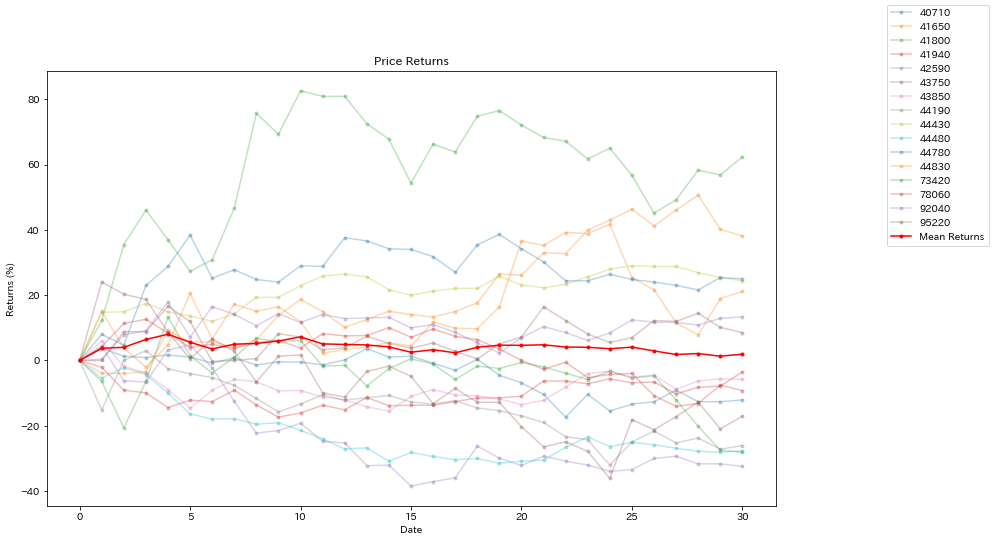

In [27]:
# is_plot_mean
df_list = [dict_target_change_ipo[code][1] for code in dict_target_change_ipo.keys()] 
vi.multiplot_matplotlib(df_list, day_period=30, is_plot_mean=True, is_plot_mean_alpha=0.3, log_y=False, log_y_base=10, log_y_linthresh=10.0)  # 複数のチャートを表示する

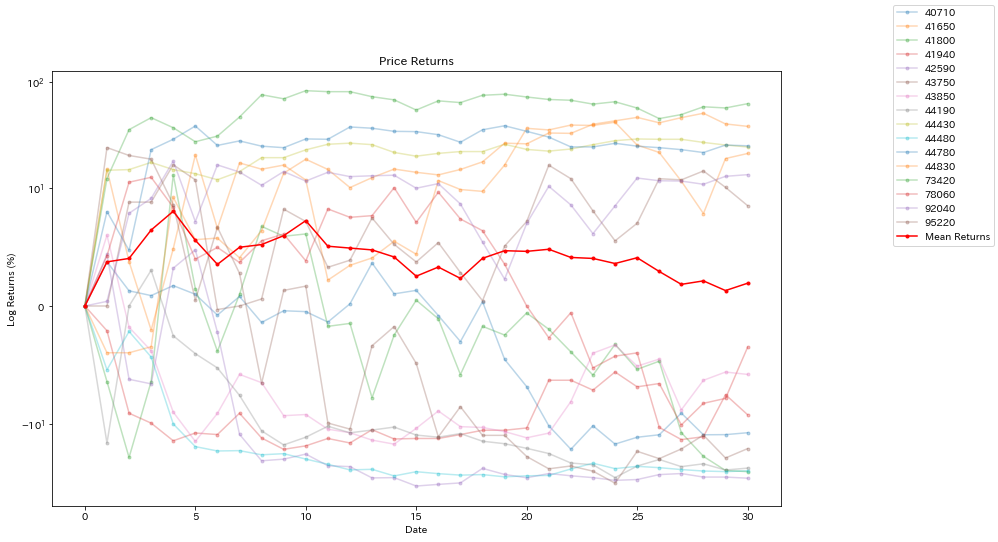

In [28]:
# is_plot_mean (log表示)
df_list = [dict_target_change_ipo[code][1] for code in dict_target_change_ipo.keys()] 
vi.multiplot_matplotlib(df_list, day_period=30, is_plot_mean=True, is_plot_mean_alpha=0.3, log_y=True, log_y_base=10, log_y_linthresh=10.0)  # 複数のチャートを表示する

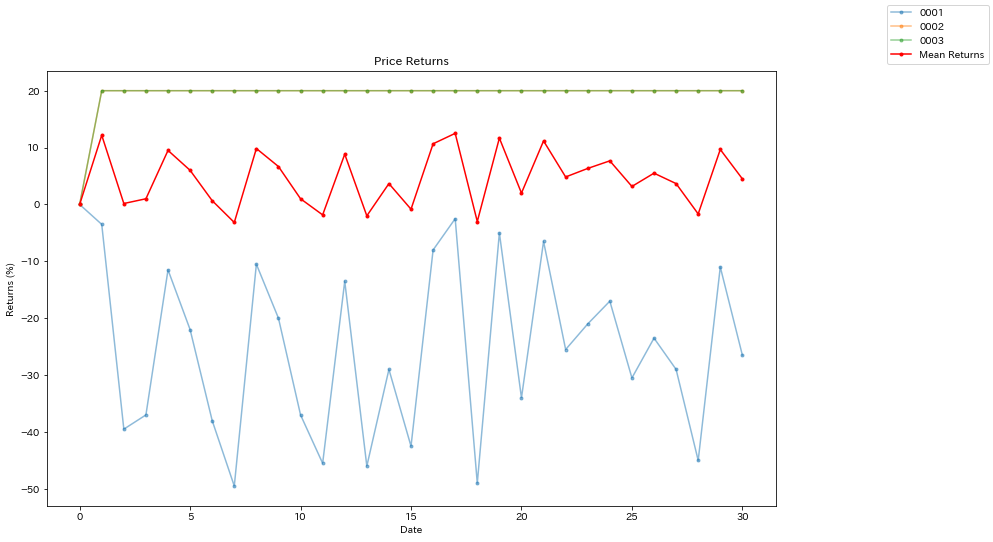

In [29]:
# 動作チェック用コード multiplot_matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ダミーデータの生成
df1 = pd.DataFrame({'date': pd.date_range('2022-01-01', periods=60, freq='D'),
                    'fix_open': np.random.randint(200, 201, 60),
                    'fix_close': np.random.randint(100, 201, 60),
                    "CODE" : "0001"})
df2 = pd.DataFrame({'date': pd.date_range('2022-01-01', periods=60, freq='D'),
                    'fix_open': np.random.randint(200, 201, 60),
                    'fix_close': np.random.randint(240, 241, 60),
                    "CODE" : "0002"})
df3 = pd.DataFrame({'date': pd.date_range('2022-01-01', periods=60, freq='D'),
                    'fix_open': np.random.randint(200, 201, 60),
                    'fix_close': np.random.randint(240, 241, 60),
                    "CODE" : "0003"})

# グラフの表示
vi.multiplot_matplotlib([df1, df2,df3], day_period=30, is_plot_mean=True, is_plot_mean_alpha=0.5, log_y=False, log_y_base=10)


In [30]:
# 20230309  1500
def pairchart(
    # self,
    df1,
    df2,
    start_day=0,
    end_day=99999999,
    indexing=False,
    corr=False,
    corr_span=50,
    add_volume=False,
    add_volume_log=False,
    diff=True,
):
    # 引数追加 , start_day, end_day
    """
    visualization.pairchart(df1,df2,スタート日付{"20200101"},エンド日付)
    これで出せるようにしてほしい
    """
    """
    ペアチャートを表示する
    :param df1:df 基準とする株価のdataframe
    :param df2:df 株価のdataframe
    :param start_day:int (例20200101) 表示期間の始まりの日
    :param end_day:int(例20200101) 表示期間の終わりの日
    :param indexing:bool Trueなら上段の株価終値を100を基準とした終値指数化に変更
    :param corr:bool Trueなら下段に相関分析を表示する、Falseなら価格差分を表示
    :param corr_span:int corrの計算期間の変更
    :param add_volume:bool Trueなら下段に出来高表示する
    :param add_volume_log:bool Trueなら出来高の表示をlog表示にする（底は10で固定）
    :param diff:bool Trueなら上段の値の差分を表示する
    :return ペアチャート
    """
    # １　データの前処理はここ
    # jpxのdateカラムはDateのため変換
    if "date" not in df1.columns:
        df1 = df1.rename(
            columns={
                f"Adjustment{c}": f"fix_{c.lower()}"
                for c in ["Open", "High", "Low", "Close", "Volume"]
            }
        )
        df1 = df1.rename(columns={"Date": "date", "Code": "CODE"})
    if "date" not in df2.columns:
        df2 = df2.rename(
            columns={
                f"Adjustment{c}": f"fix_{c.lower()}"
                for c in ["Open", "High", "Low", "Close", "Volume"]
            }
        )
        df2 = df2.rename(columns={"Date": "date", "Code": "CODE"})
    code1 = df1["CODE"][0]
    code2 = df2["CODE"][0]
    # 期間範囲指定
    df1 = df1[(df1["date"] >= f"{start_day}") & (df1["date"] <= f"{end_day}")]
    df2 = df2[(df2["date"] >= f"{start_day}") & (df2["date"] <= f"{end_day}")]
    # 指数化の計算
    if indexing == True:
        df1 = df1.reset_index()
        df1["fix_close"] = df1["fix_close"] / df1["fix_close"][0] * 100
        df2 = df2.reset_index()
        df2["fix_close"] = df2["fix_close"] / df2["fix_close"][0] * 100
    # 差分or相関係数の作成
    if corr == False:
        param = df1["fix_close"] - df2["fix_close"]
        param_name = "差分"
    else:
        param = df1["fix_close"].rolling(corr_span).corr(df2["fix_close"])
        param_name = "相関分析"
    # 出来高にparam変更
    if add_volume == True:
        param_name = "出来高"
    # subplotsで複数のグラフ画面を作成する
    row_heights_param = [3, 1]
    row_param = 2
    # ２　make_subplots設定はここ
    # 出来高のsubplots設定変更（3:2のおおきさに変更)
    if add_volume == True:
        row_heights_param[1] = 2
    fig = make_subplots(
        rows=row_param,  # 行数設定
        cols=1,  # 列数設定
        # shared_yaxes='all', #y軸を共有する
        shared_xaxes="all",  # x軸を共有する
        vertical_spacing=0.1,  # サブプロット行間のスペース
        row_heights=row_heights_param,  # グラフの大きさ 相対的比率
        subplot_titles=["chart", param_name],  # グラフ上のタイトル設定
    )
    # ３　add_trace グラフの挿入はここ
    # add_traceでグラフを入れる
    fig.add_trace(
        go.Scatter(
            x=df1["date"],
            y=df1["fix_close"],
            mode="lines",
            name=f"{code1}",
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=df1["date"],
            y=df2["fix_close"],
            mode="lines",
            name=f"{code2}",
        ),
        row=1,
        col=1,
    )
    # 下段に差分または相関係数のグラフを作成する
    if corr == True:
        fig.add_trace(
            go.Scatter(
                x=df1["date"],
                y=param,
                mode="lines",
                name=param_name,
            ),
            row=2,
            col=1,
        )
    if add_volume == True:
        fig.add_trace(
            go.Bar(
                x=df1["date"],
                y=df1["fix_volume"],
                # mode="lines",
                name=f"{code1}",
                opacity=0.3,
                marker_color="blue",
            ),
            row=2,
            col=1,
            # secondary_y=True,
        )
        fig.add_trace(
            go.Bar(
                x=df2["date"],
                y=df2["fix_volume"],
                # mode="lines",
                name=f"{code2}",
                opacity=0.3,
                marker_color="red",
            ),
            row=2,
            col=1,
            # secondary_y=True,
        )
    # ４　レイアウト設定はここ
    # layoutでレイアウト設定をする
    height_param = 800
    if add_volume == True:
        height_param += 100
    fig.update_layout(
        # グラフタイトル
        # title_text="OHLC",
        # 凡例表示
        showlegend=True,
        # 凡例の位置変更
        xaxis_rangeslider=dict(
            visible=False,
        ),  # レンジスライダー削除
        yaxis=dict(fixedrange=False),  # y軸のズームを可能にする
        height=height_param,  # グラフ高さの編集
        width=900,  # グラフ横幅の編集
        margin=dict(l=0, r=0, t=30, b=0),  # グラフ間の隙間幅の調整
    )
    # 土日祝の隙間を削除するためにrangebreaks作成して、update_xaxesで反映させる
    # 日付objectをdatetime型に変換
    date = pd.to_datetime(df1["date"])
    # 日付リストを取得
    d_all = pd.date_range(start=df1["date"].iloc[0], end=df1["date"].iloc[-1])
    # 株価データの日付リストを取得
    d_obs = [d.strftime("%Y-%m-%d") for d in date]
    # 株価データの日付データに含まれていない日付を抽出
    d_breaks = [d for d in d_all.strftime("%Y-%m-%d").tolist() if not d in d_obs]
    fig.update_xaxes(rangebreaks=[dict(values=d_breaks)])
    # 相関分析時にy軸の最大最小値の固定化
    if (corr == True) and (add_volume == False):
        fig.update_yaxes(range=[-1, 1], row=2, col=1)
    # y軸をlogに変更する
    if (add_volume == True) and (add_volume_log == True):
        fig.update_yaxes(type="log", row=2, col=1)
    # グラフ出力
    fig.show()